In [1]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

sys.path.insert(0, "..") 
from src.data import make_dataset
from src.features import build_features
from src.visualization import visualize

pd.set_option("display.precision", 5)
pd.set_option("display.max.columns", None)
pd.options.display.float_format = '{:6.5f}'.format

from tensorflow.keras.layers import BatchNormalization

tf.random.set_seed(42)

# Naive model

Het eerste model wat we willen proberen is de 'naive voorspelling'. Dit is een base line model ter beoordeling van de resultaten van de overige modellen. Er zijn 215 government bonds met gemiddeld zo'n 1000 dagen data. 

In [2]:
# Shape of the Bond data is simple: Bond, rate_dt, price
df_price = make_dataset.read_pkl('price')

# Create a model that will predict 10 steps into the future, given as much data as available.


2022-01-09 22:48:54.030 | INFO     | src.data.make_dataset:read_pkl:364 - Load preprocessed price data


In [3]:
df_price['reference_identifier'].unique()

<StringArray>
['BE0000332412', 'NL0010721999', 'IE00B6X95T99', 'NL0010733424',
 'XS1062909384', 'DE0001102358', 'AT0000A185T1', 'FR0011962398',
 'FR0011883966', 'DE0001102366',
 ...
 'FR0011196856', 'DE0001135499', 'FR0011337880', 'BE0000325341',
 'BE0000328378', 'DE0001102309', 'NL0010418810', 'AT0000A105W3',
 'FR0011486067', 'NL0010514246']
Length: 215, dtype: string

Eerst maar eens een voorspelling doen van 1 bond

2022-01-09 22:52:12.576 | INFO     | src.data.make_dataset:read_pkl:364 - Load preprocessed price data
2022-01-09 22:52:12.602 | INFO     | src.data.make_dataset:split_data:414 - Data 427
2022-01-09 22:52:12.602 | INFO     | src.data.make_dataset:split_data:415 - Training 298
2022-01-09 22:52:12.603 | INFO     | src.data.make_dataset:split_data:416 - Validation 86
2022-01-09 22:52:12.604 | INFO     | src.data.make_dataset:split_data:417 - Test 43


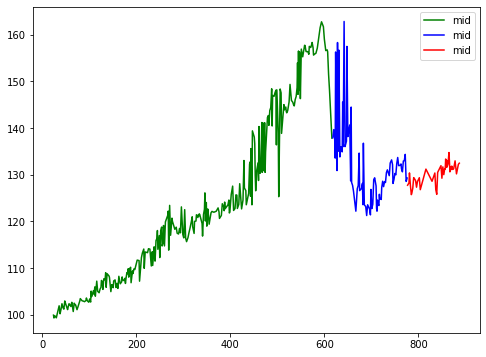

In [5]:
(df_train, df_val, df_test) = make_dataset.read_single_bond('NL0010721999')
visualize.lplot([df_train, df_val, df_test ])

In [5]:
from src.models import base_model
from src.models import window

w = window.WindowGenerator(24,24,1,df_train,df_val, df_test, ['mid'])

# For sampling business Days
#    from pandas.tseries.offsets import BDay
#    pd.date_range('2015-07-01', periods=5, freq=BDay())

In [6]:
w.train.element_spec

(TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))

In [7]:
for example_inputs, example_labels in w.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 1)
Labels shape (batch, time, features): (32, 24, 1)


In [8]:
single_step_window = window.WindowGenerator(
    input_width=1, label_width=1, shift=1, df_train = df_train,df_val = df_val, df_test = df_test,
    label_columns=['mid'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['mid']

In [9]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [10]:
baseline = base_model.Baseline(label_index=w.column_indices['mid'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

3/3 [==============================] - 0s 1ms/step - loss: 84.3663 - mean_absolute_error: 5.3021


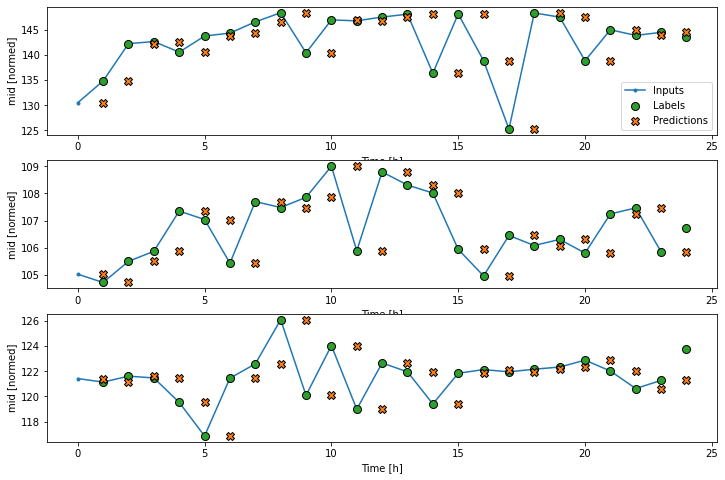

In [11]:
w.plot(baseline)

In [12]:

print('Input shape:', w.example[0].shape)
print('Output shape:', baseline(w.example[0]).shape)

Input shape: (32, 24, 1)
Output shape: (32, 24, 1)


Lineair Regression model

In [13]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [14]:
print('Input shape:', w.example[0].shape)
print('Output shape:', linear(w.example[0]).shape)

Input shape: (32, 24, 1)
Output shape: (32, 24, 1)


In [15]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=10):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [16]:
history = compile_and_fit(linear, w)

val_performance['Linear'] = linear.evaluate(w.val)
performance['Linear'] = linear.evaluate(w.test, verbose=0)

Epoch 1/100
9/9 [==============================] - 0s 15ms/step - loss: 2812.9407 - mean_absolute_error: 52.4712 - val_loss: 3033.5835 - val_mean_absolute_error: 54.6400
Epoch 2/100
9/9 [==============================] - 0s 8ms/step - loss: 2695.3713 - mean_absolute_error: 51.3593 - val_loss: 2906.7935 - val_mean_absolute_error: 53.4658
Epoch 3/100
9/9 [==============================] - 0s 8ms/step - loss: 2581.5959 - mean_absolute_error: 50.2556 - val_loss: 2783.1921 - val_mean_absolute_error: 52.2957
Epoch 4/100
9/9 [==============================] - 0s 8ms/step - loss: 2470.1943 - mean_absolute_error: 49.1564 - val_loss: 2663.6809 - val_mean_absolute_error: 51.1386
Epoch 5/100
9/9 [==============================] - 0s 8ms/step - loss: 2363.9458 - mean_absolute_error: 48.0726 - val_loss: 2547.3645 - val_mean_absolute_error: 49.9867
Epoch 6/100
9/9 [==============================] - 0s 8ms/step - loss: 2258.8396 - mean_absolute_error: 46.9915 - val_loss: 2435.9197 - val_mean_absolute_

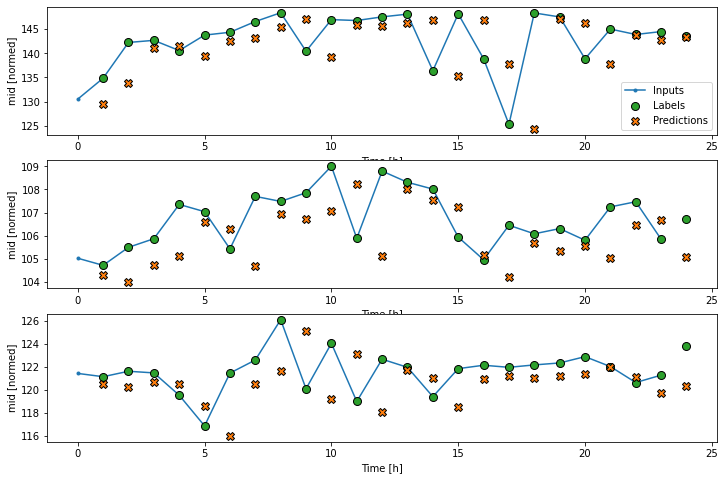

In [17]:
w.plot(linear)

Add 1 feature: remaining duration

In [18]:
df_train, df_val, df_test = make_dataset.read_bond_with_features('NL0010721999',['remain_duration'])


2022-01-09 15:52:53.557 | INFO     | src.data.make_dataset:read_pkl:364 - Load preprocessed price data
2022-01-09 15:52:53.573 | INFO     | src.data.make_dataset:read_pkl:364 - Load preprocessed bonds data
2022-01-09 15:52:53.596 | INFO     | src.features.build_features:add_duration:13 - Add remaining duration...
2022-01-09 15:52:53.599 | INFO     | src.features.build_features:encode_coupon_freq:22 - Encode coupon frequency coupon_frq
2022-01-09 15:52:53.600 | INFO     | src.features.build_features:encode_cfi:50 - Encode CFI Code column cfi_code
2022-01-09 15:52:53.605 | INFO     | src.features.build_features:encode_onehot:35 - One Hot Encode column country
2022-01-09 15:52:53.611 | INFO     | src.features.build_features:encode_onehot:35 - One Hot Encode column isin
2022-01-09 15:52:53.615 | INFO     | src.features.build_features:encode_onehot:35 - One Hot Encode column issuer_name
2022-01-09 15:52:53.618 | INFO     | src.features.build_features:encode_onehot:35 - One Hot Encode column

In [19]:
w2 = window.WindowGenerator(24,24,2,df_train,df_val, df_test, ['mid'])

In [20]:
linear = tf.keras.Sequential([        
    tf.keras.layers.Normalization(axis = -1),    
    tf.keras.layers.Dense(units=1),
])


In [21]:
config = {"batchnorm" : False, 
          "units" : 24, 
          "hidden" : 3,
          "activation" : "relu",
          "dropout": 0}

In [22]:
basemodel = base_model.Basemodel(config)

2022-01-09 15:52:54.261 | INFO     | src.models.base_model:__init__:24 - init base


In [23]:
print('Input shape:', w2.example[0].shape)
print('Output shape:', basemodel(w2.example[0]).shape)

Input shape: (32, 24, 2)
Output shape: (32, 24, 1)


In [24]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3607819516535475792
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2253809255
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18350385015164234464
 physical_device_desc: "device: 0, name: GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [25]:
history = compile_and_fit(basemodel, w2)

val_performance['Linear'] = basemodel.evaluate(w2.val)
performance['Linear'] = basemodel.evaluate(w2.test, verbose=0)

Epoch 1/100
9/9 [==============================] - 0s 15ms/step - loss: 15384.8154 - mean_absolute_error: 122.9454 - val_loss: 16920.2031 - val_mean_absolute_error: 129.8554
Epoch 2/100
9/9 [==============================] - 0s 7ms/step - loss: 15384.8154 - mean_absolute_error: 122.9454 - val_loss: 16920.2031 - val_mean_absolute_error: 129.8554
Epoch 3/100
9/9 [==============================] - 0s 8ms/step - loss: 15384.8154 - mean_absolute_error: 122.9454 - val_loss: 16920.2012 - val_mean_absolute_error: 129.8554
Epoch 4/100
9/9 [==============================] - 0s 8ms/step - loss: 15384.8164 - mean_absolute_error: 122.9454 - val_loss: 16920.2031 - val_mean_absolute_error: 129.8554
Epoch 5/100
9/9 [==============================] - 0s 7ms/step - loss: 15384.8154 - mean_absolute_error: 122.9454 - val_loss: 16920.2031 - val_mean_absolute_error: 129.8554
Epoch 6/100
9/9 [==============================] - 0s 7ms/step - loss: 15384.8154 - mean_absolute_error: 122.9454 - val_loss: 16920.20

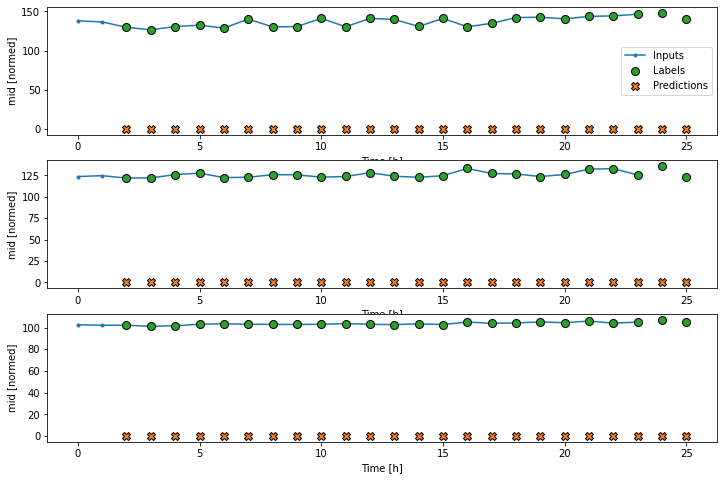

In [26]:
w2.plot(basemodel)

In [27]:
w2

Total window size: 26
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25]
Label column name(s): ['mid']

In [28]:
history = compile_and_fit(linear, w)

val_performance['Linear'] = linear.evaluate(w.val)
performance['Linear'] = linear.evaluate(w.test, verbose=0)

Epoch 1/100
9/9 [==============================] - 0s 15ms/step - loss: 415.4247 - mean_absolute_error: 19.8366 - val_loss: 456.8405 - val_mean_absolute_error: 20.0395
Epoch 2/100
9/9 [==============================] - 0s 7ms/step - loss: 372.1122 - mean_absolute_error: 18.7304 - val_loss: 412.0657 - val_mean_absolute_error: 18.9103
Epoch 3/100
9/9 [==============================] - 0s 8ms/step - loss: 331.9850 - mean_absolute_error: 17.6409 - val_loss: 370.6303 - val_mean_absolute_error: 17.8357
Epoch 4/100
9/9 [==============================] - 0s 8ms/step - loss: 294.8006 - mean_absolute_error: 16.5715 - val_loss: 332.8846 - val_mean_absolute_error: 16.7946
Epoch 5/100
9/9 [==============================] - 0s 8ms/step - loss: 261.0212 - mean_absolute_error: 15.5331 - val_loss: 298.6430 - val_mean_absolute_error: 15.7947
Epoch 6/100
9/9 [==============================] - 0s 8ms/step - loss: 230.2172 - mean_absolute_error: 14.5259 - val_loss: 267.7874 - val_mean_absolute_error: 14.85

In [29]:
plt.bar(x = range(len(df_train.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(df_train.columns)))
_ = axis.set_xticklabels(df_train.columns, rotation=90)

AttributeError: 'Normalization' object has no attribute 'kernel'

Dense Neural Network

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, wide_window)

val_performance['Dense'] = dense.evaluate(wide_window.val)
performance['Dense'] = dense.evaluate(wide_window.test, verbose=0)

In [ ]:
CONV_WIDTH = 3
conv_window = window.WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    df_train = df_train,
    df_val = df_val,
    df_test = df_test,
    label_columns=['mid'])

conv_window

In [ ]:
conv_window.plot()
plt.title("Given 3 days of inputs, predict 1 day into the future.")

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

In [ ]:
history = compile_and_fit(conv_model, conv_window)

val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

In [ ]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

In [ ]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = window.WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    df_train = df_train,
    df_val = df_val,
    df_test = df_test,
    label_columns=['mid'])

wide_conv_window

In [ ]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

In [ ]:
wide_conv_window.plot(conv_model)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

In [ ]:
history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

In [ ]:
wide_window.plot(lstm_model)

In [ ]:
import numpy as np
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()